In [ ]:
!pip install -q -U evaluate trl rouge-score bitsandbytes==0.49.2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 62.5 MB/s eta 0:00:00


In [ ]:
import glob
import os
import re
from collections import Counter, defaultdict
from pathlib import Path

import evaluate
import matplotlib.pyplot as plt
import torch
import yaml
from datasets import ClassLabel, Dataset, concatenate_datasets
from datasets.formatting.formatting import LazyBatch
from huggingface_hub import login
from peft import LoraConfig, PeftModel
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from transformers import (
    BitsAndBytesConfig,
    EarlyStoppingCallback,
    Gemma3ForConditionalGeneration,
    Gemma3Processor,
)
from trl import SFTConfig, SFTTrainer

SEED = 2

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ROOT_DIR = Path("/content/drive/MyDrive/MedGemma2026/main")
DATA_DIR = ROOT_DIR / "data"
CONFIG_DIR = ROOT_DIR / "config"

print(f"Root directory: {ROOT_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Config directory: {CONFIG_DIR}")

Root directory: /content/drive/MyDrive/MedGemma2026/main
Data directory: /content/drive/MyDrive/MedGemma2026/main/data
Config directory: /content/drive/MyDrive/MedGemma2026/main/config


In [ ]:
login("")  # replace with your Hugging Face token

In [ ]:
def load_data(*, report_path: str, image_path: str) -> list[dict]:
    data = []

    for text_file_path in glob.glob(os.path.join(report_path, "*.txt")):
        base_name = os.path.splitext(os.path.basename(text_file_path))[0]

        with open(text_file_path) as stream:
            raw_content = stream.read()

        data.append(
            {
                "id": base_name,
                "text": raw_content.strip(),
                "image": os.path.join(image_path, f"{base_name.upper()}.tif"),
            }
        )

    return data


raw_data = load_data(
    report_path=str(DATA_DIR / "reports"),
    image_path=str(DATA_DIR / "tiff_images"),
)
raw_data

[{'id': 'Img316',
  'text': 'Breast Composition:\n\nfibro fatty and glandular breast parenchyma (ACR-B).\n\nBIRADS: 4b\n\nFindings:\nsmall well-defined irregular soft opacity seen in the outer quadrant of the breast suggests moderate suspicious malignant lesion (BIRADS 4b)\nskin and nipple appear normal.\nbenign vascular calcifications seen.\ntwo enlarged axillary nodes seen',
  'image': '/content/drive/MyDrive/MedGemma2026/main/data/tiff_images/IMG316.tif'},
 {'id': 'Img317',
  'text': 'Breast Composition:\nfibro fatty and glandular breast parenchyma (ACR-B).\n\nBIRADS: 4b\n\nFindings:\nsmall well-defined irregular soft opacity seen in the upper quadrant of the breast suggests moderate suspicious malignant lesion (BIRADS 4b)\nskin, nipple, and pectoral muscle appear normal.\nbenign vascular calcifications seen.\nmultiple enlarged axillary nodes seen.',
  'image': '/content/drive/MyDrive/MedGemma2026/main/data/tiff_images/IMG317.tif'},
 {'id': 'Img318',
  'text': 'Breast Composition:\n

In [ ]:
def extract_birads_level(text: str) -> str:
    match = re.search(r"BIRADS:\s*(.+?)(?:\n|$)", text, re.IGNORECASE)
    return (
        re.sub(r"\s*,\s*", " and ", match.group(1).strip().lower())
        if match
        else "unknown"
    )


def extract_acr_density(text: str) -> str | None:
    match = re.search(r"\(ACR[\s-]+([A-D])\s*\)", text, re.IGNORECASE)
    return match.group(1).upper() if match else None


birads_distribution = defaultdict(int)
acr_distribution = defaultdict(int)

for record in raw_data:
    record["birads"] = extract_birads_level(record["text"])
    record["acr_density"] = extract_acr_density(record["text"])

    if record["birads"] == "unknown":
        print(f"Unknown BIRADS in {record['id']}")

    birads_distribution[record["birads"]] += 1
    acr_distribution[record["acr_density"]] += 1


print(f"BIRADS Level Distribution ({len(raw_data)} records):")

for level, count in sorted(birads_distribution.items(), key=lambda x: (-x[1], x[0])):
    print(
        f"- BIRADS {level:<10}: {count:3d} records ({(count / len(raw_data)) * 100:.2f}%)"
    )

print(f"\nACR Density Distribution ({len(raw_data)} records):")

for level, count in sorted(
    acr_distribution.items(), key=lambda x: (x[0] is None, x[0] or "", -x[1])
):
    print(
        f"- ACR {str(level):<10}: {count:3d} records ({(count / len(raw_data)) * 100:.2f}%)"
    )

BIRADS Level Distribution (510 records):
- BIRADS 1         : 209 records (40.98%)
- BIRADS 3         : 118 records (23.14%)
- BIRADS 4c        :  51 records (10.00%)
- BIRADS 4a        :  35 records (6.86%)
- BIRADS 4b        :  30 records (5.88%)
- BIRADS 2         :  25 records (4.90%)
- BIRADS 5         :  18 records (3.53%)
- BIRADS 3 and 4a  :   4 records (0.78%)
- BIRADS 3 and 4b  :   4 records (0.78%)
- BIRADS 2 and 3   :   3 records (0.59%)
- BIRADS 4         :   3 records (0.59%)
- BIRADS 2 and 4c  :   2 records (0.39%)
- BIRADS 3 and 4c  :   2 records (0.39%)
- BIRADS 0         :   1 records (0.20%)
- BIRADS 3 and 5   :   1 records (0.20%)
- BIRADS 4a and 4b :   1 records (0.20%)
- BIRADS 4a and 4c :   1 records (0.20%)
- BIRADS 4b and 3  :   1 records (0.20%)
- BIRADS 4c and 3  :   1 records (0.20%)

ACR Density Distribution (510 records):
- ACR A         :  79 records (15.49%)
- ACR B         : 203 records (39.80%)
- ACR C         : 186 records (36.47%)
- ACR D         :  

In [ ]:
raw_data[:3]

[{'id': 'Img316',
  'text': 'Breast Composition:\n\nfibro fatty and glandular breast parenchyma (ACR-B).\n\nBIRADS: 4b\n\nFindings:\nsmall well-defined irregular soft opacity seen in the outer quadrant of the breast suggests moderate suspicious malignant lesion (BIRADS 4b)\nskin and nipple appear normal.\nbenign vascular calcifications seen.\ntwo enlarged axillary nodes seen',
  'image': '/content/drive/MyDrive/MedGemma2026/main/data/tiff_images/IMG316.tif',
  'birads': '4b',
  'acr_density': 'B'},
 {'id': 'Img317',
  'text': 'Breast Composition:\nfibro fatty and glandular breast parenchyma (ACR-B).\n\nBIRADS: 4b\n\nFindings:\nsmall well-defined irregular soft opacity seen in the upper quadrant of the breast suggests moderate suspicious malignant lesion (BIRADS 4b)\nskin, nipple, and pectoral muscle appear normal.\nbenign vascular calcifications seen.\nmultiple enlarged axillary nodes seen.',
  'image': '/content/drive/MyDrive/MedGemma2026/main/data/tiff_images/IMG317.tif',
  'birads':

In [ ]:
dataset = Dataset.from_list(raw_data).class_encode_column("birads")
dataset

Casting to class labels:   0%|          | 0/510 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'text', 'image', 'birads', 'acr_density'],
    num_rows: 510
})

In [ ]:
birads_counts = Counter(record["birads"] for record in raw_data)
acr_counts = Counter(record["acr_density"] for record in raw_data)

rare_birads = {level for level, count in birads_counts.items() if count < 2}
common_birads = {level for level, count in birads_counts.items() if count >= 2}

rare_records = [r for r in raw_data if r["birads"] in rare_birads]
common_records = [r for r in raw_data if r["birads"] in common_birads]

birads_class_label = ClassLabel(names=sorted(birads_counts))
acr_class_label = ClassLabel(names=sorted(k for k in acr_counts if k is not None))

data = (
    Dataset.from_list(common_records)
    .cast_column("birads", birads_class_label)
    .cast_column("acr_density", acr_class_label)
    .train_test_split(test_size=0.3, seed=SEED, stratify_by_column="birads")
)

if rare_records:
    rare_dataset = (
        Dataset.from_list(rare_records)
        .cast_column("birads", birads_class_label)
        .cast_column("acr_density", acr_class_label)
    )
    data["train"] = concatenate_datasets([data["train"], rare_dataset])

data["validation"] = data.pop("test")

print("Training set:")

for level, count in sorted(
    Counter(record["birads"] for record in data["train"]).items(),
    key=lambda x: (-x[1], x[0]),
):
    print(f"- BIRADS {level:<3}: {count:3d} ({count / len(data['train']) * 100:.2f}%)")

print("\nValidation set:")

for level, count in sorted(
    Counter(record["birads"] for record in data["validation"]).items(),
    key=lambda x: (-x[1], x[0]),
):
    print(
        f"- BIRADS {level:<3}: {count:3d} ({count / len(data['validation']) * 100:.2f}%)"
    )

print("\nACR Density distribution (full dataset):")

for level, count in sorted(
    acr_counts.items(), key=lambda x: (x[0] is None, x[0] or "", -x[1])
):
    print(f"- ACR {str(level):<3}: {count:3d} ({count / len(raw_data) * 100:.2f}%)")

data

Casting the dataset:   0%|          | 0/504 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/504 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/6 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/6 [00:00<?, ? examples/s]

Training set:
- BIRADS 1  : 146 (40.78%)
- BIRADS 5  :  82 (22.91%)
- BIRADS 16 :  36 (10.06%)
- BIRADS 11 :  24 (6.70%)
- BIRADS 14 :  21 (5.87%)
- BIRADS 2  :  18 (5.03%)
- BIRADS 18 :  13 (3.63%)
- BIRADS 6  :   3 (0.84%)
- BIRADS 7  :   3 (0.84%)
- BIRADS 3  :   2 (0.56%)
- BIRADS 10 :   2 (0.56%)
- BIRADS 0  :   1 (0.28%)
- BIRADS 4  :   1 (0.28%)
- BIRADS 8  :   1 (0.28%)
- BIRADS 9  :   1 (0.28%)
- BIRADS 12 :   1 (0.28%)
- BIRADS 13 :   1 (0.28%)
- BIRADS 15 :   1 (0.28%)
- BIRADS 17 :   1 (0.28%)

Validation set:
- BIRADS 1  :  63 (41.45%)
- BIRADS 5  :  36 (23.68%)
- BIRADS 16 :  15 (9.87%)
- BIRADS 11 :  11 (7.24%)
- BIRADS 14 :   9 (5.92%)
- BIRADS 2  :   7 (4.61%)
- BIRADS 18 :   5 (3.29%)
- BIRADS 3  :   1 (0.66%)
- BIRADS 4  :   1 (0.66%)
- BIRADS 6  :   1 (0.66%)
- BIRADS 7  :   1 (0.66%)
- BIRADS 8  :   1 (0.66%)
- BIRADS 10 :   1 (0.66%)

ACR Density distribution (full dataset):
- ACR A  :  79 (15.49%)
- ACR B  : 203 (39.80%)
- ACR C  : 186 (36.47%)
- ACR D  :  40 (7.

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'image', 'birads', 'acr_density'],
        num_rows: 358
    })
    validation: Dataset({
        features: ['id', 'text', 'image', 'birads', 'acr_density'],
        num_rows: 152
    })
})

In [ ]:
data["train"][0]["image"]

'/content/drive/MyDrive/MedGemma2026/main/data/tiff_images/IMG377.tif'

In [ ]:
def load_prompts(file_path: Path) -> dict:
    if not file_path.exists():
        raise FileNotFoundError(f"Prompt config not found: {file_path}")

    with open(file_path) as stream:
        return yaml.safe_load(stream)


prompts = load_prompts(CONFIG_DIR / "prompts.yaml")
mammography_analysis_prompt = prompts["mammography_analysis"]
mammography_analysis_prompt

{'system': 'You are an expert Breast Radiologist with deep knowledge of the ACR BI-RADS (Breast Imaging-Reporting and Data System) lexicon.\nYour task is to analyze 2D mammography images to identify anatomical structures, detect medical devices, and characterize abnormalities.\n',
 'user_instruction': 'Analyze the provided 2D mammogram view. Provide a structured report covering the following four sections:\n\n1. **Anatomical Landmarks & Quality**:\n   - Identify visible anatomical structures.\n   - Comment on the view type (CC or MLO).\n\n2. **Medical Devices**:\n   - Detect and list any visible medical devices. If none, state "None".\n\n3. **Findings & Abnormalities**:\n   - Describe masses, calcifications, asymmetries, or distortions.\n   - STRICTLY use ACR BI-RADS lexicon (Shape, Margins, Density).\n\n4. **BI-RADS Assessment**:\n   - Assign a single BI-RADS Category (0-6).\n   - Provide a rationale.\n\nOutput the result in a clear, markdown-formatted report.\n'}

In [ ]:
def resize_image(image_path: str, max_size: int = 512) -> Image.Image:
    image = Image.open(image_path).convert("RGB")
    image.thumbnail((max_size, max_size), resample=Image.Resampling.LANCZOS)
    return image

In [ ]:
def transform_and_format_train_data(batch: LazyBatch) -> LazyBatch:
    batch["image"] = [resize_image(image_path) for image_path in batch["image"]]

    batch["messages"] = [
        [
            {
                "role": "system",
                "content": [
                    {"type": "text", "text": mammography_analysis_prompt["system"]}
                ],
            },
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {
                        "type": "text",
                        "text": mammography_analysis_prompt["user_instruction"],
                    },
                ],
            },
            {"role": "assistant", "content": [{"type": "text", "text": text}]},
        ]
        for text in batch["text"]
    ]

    return batch


data["train"].set_transform(transform_and_format_train_data)

In [ ]:
data["train"][0]

{'id': 'Img377',
 'text': 'BREAST COMPOSITION: fibro fatty and glandular breast parenchyma (ACR C)\n\nFINDINGS: No abnormal soft opacity or microcalcifications seen.\n\nskin, nipple, and pectoral muscle appear normal. \n\nno significant axillary adenopathy seen. \n\nBIRADS: 1',
 'image': <PIL.Image.Image image mode=RGB size=405x512>,
 'birads': 1,
 'acr_density': 2,
 'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are an expert Breast Radiologist with deep knowledge of the ACR BI-RADS (Breast Imaging-Reporting and Data System) lexicon.\nYour task is to analyze 2D mammography images to identify anatomical structures, detect medical devices, and characterize abnormalities.\n'}]},
  {'role': 'user',
   'content': [{'type': 'image'},
    {'type': 'text',
     'text': 'Analyze the provided 2D mammogram view. Provide a structured report covering the following four sections:\n\n1. **Anatomical Landmarks & Quality**:\n   - Identify visible anatomical structure

In [ ]:
def transform_and_format_validation_data(batch: LazyBatch) -> LazyBatch:
    batch["image"] = [resize_image(image_path) for image_path in batch["image"]]

    batch["messages"] = [
        [
            {
                "role": "system",
                "content": [
                    {"type": "text", "text": mammography_analysis_prompt["system"]}
                ],
            },
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {
                        "type": "text",
                        "text": mammography_analysis_prompt["user_instruction"],
                    },
                ],
            },
        ]
        for _ in batch["text"]
    ]

    return batch


data["validation"].set_transform(transform_and_format_validation_data)

In [ ]:
data["validation"][0]

{'id': 'Img314',
 'text': 'BREAST COMPOSITION:  \nfibro fatty and glandular breast parenchyma (ACR B).\n\nBIRADS: 1\n\nFINDINGS: \n\nno abnormal soft opacity or microcalcification seen.\n\nskin, nipple, and pectoral muscle appear normal. \n\nno significant axillary adenopathy.',
 'image': <PIL.Image.Image image mode=RGB size=405x512>,
 'birads': 1,
 'acr_density': 1,
 'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are an expert Breast Radiologist with deep knowledge of the ACR BI-RADS (Breast Imaging-Reporting and Data System) lexicon.\nYour task is to analyze 2D mammography images to identify anatomical structures, detect medical devices, and characterize abnormalities.\n'}]},
  {'role': 'user',
   'content': [{'type': 'image'},
    {'type': 'text',
     'text': 'Analyze the provided 2D mammogram view. Provide a structured report covering the following four sections:\n\n1. **Anatomical Landmarks & Quality**:\n   - Identify visible anatomical structur

In [ ]:
model_id = "google/medgemma-1.5-4b-it"

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_storage=torch.bfloat16,
)

model = Gemma3ForConditionalGeneration.from_pretrained(
    model_id,
    dtype=torch.bfloat16,
    device_map="auto",
    quantization_config=quantization_config,
)

processor = Gemma3Processor.from_pretrained(model_id, use_fast=True)
processor.tokenizer.padding_side = "right"

In [ ]:
peft_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=16,
    target_modules="all-linear",
    lora_alpha=16,
    lora_dropout=0.05,
    modules_to_save=["lm_head", "embed_tokens"],
    ensure_weight_tying=True,
)

In [ ]:
def collate_fn(examples: list[dict]):
    texts = []
    images = []

    for example in examples:
        images.append([example["image"]])
        texts.append(
            processor.apply_chat_template(
                example["messages"], add_generation_prompt=False, tokenize=False
            ).strip()
        )

    batch = processor(images=images, text=texts, return_tensors="pt", padding=True)

    labels = batch["input_ids"].clone()

    image_token_id = [
        processor.tokenizer.convert_tokens_to_ids(
            processor.tokenizer.special_tokens_map["boi_token"]
        )
    ]

    labels[
        (labels == processor.tokenizer.pad_token_id)
        | (labels == image_token_id)
        | (labels == 262144)
    ] = -100

    batch["labels"] = labels
    return batch

In [ ]:
HUB_MODEL_ID = "medgemma-1.5-4b-it-sft-lora-dmid"

args = SFTConfig(
    output_dir=HUB_MODEL_ID,
    eval_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=16,
    learning_rate=2e-4,
    max_grad_norm=0.3,
    num_train_epochs=50,
    lr_scheduler_type="linear",
    warmup_steps=0.03,
    logging_steps=50,
    save_strategy="steps",
    bf16=True,
    eval_steps=50,
    remove_unused_columns=False,
    label_names=["labels"],
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    report_to="none",
    push_to_hub=True,
    hub_model_id=HUB_MODEL_ID,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    dataset_kwargs={"skip_prepare_dataset": True},
)

trainer = SFTTrainer(
    model,
    args=args,
    data_collator=collate_fn,
    train_dataset=data["train"],
    eval_dataset=data["validation"],
    processing_class=processor,
    peft_config=peft_config,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

trainer.train()

Best epoch: 33.4 | Best eval loss: 0.0061
Suggested num_train_epochs = 33


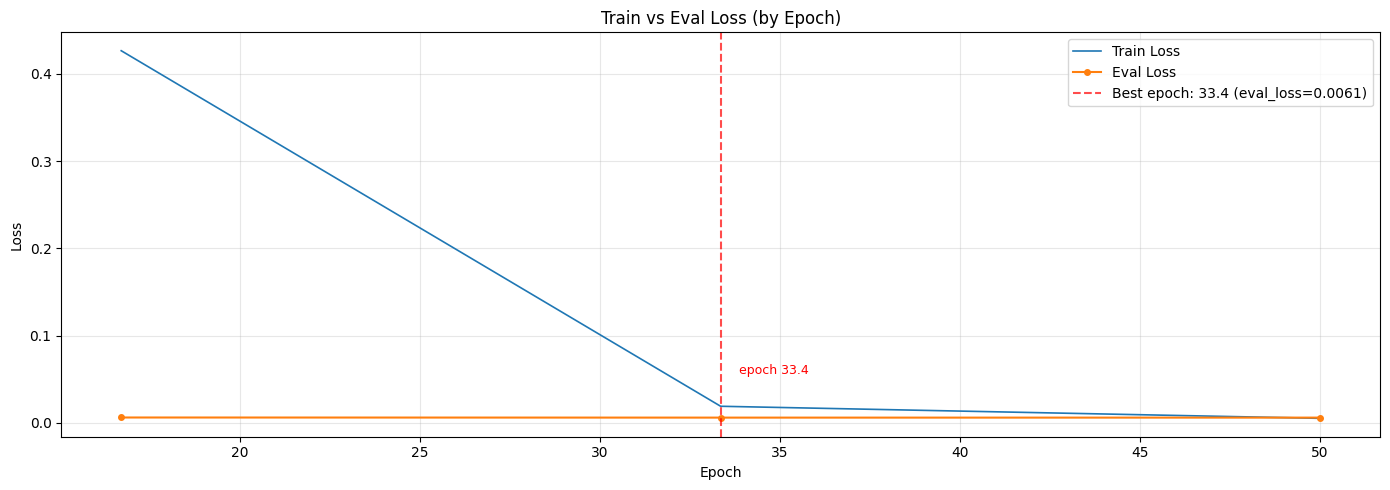

In [ ]:
log_history = trainer.state.log_history

train_epochs, train_losses = [], []
eval_epochs, eval_losses = [], []

for entry in log_history:
    if "loss" in entry and "eval_loss" not in entry:
        train_epochs.append(entry["epoch"])
        train_losses.append(entry["loss"])
    if "eval_loss" in entry:
        eval_epochs.append(entry["epoch"])
        eval_losses.append(entry["eval_loss"])

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(train_epochs, train_losses, linewidth=1.2, color="tab:blue", label="Train Loss")
ax.plot(eval_epochs, eval_losses, linewidth=1.5, color="tab:orange", marker="o", markersize=4, label="Eval Loss")

if eval_losses:
    best_idx = eval_losses.index(min(eval_losses))
    best_epoch = eval_epochs[best_idx]
    best_loss = eval_losses[best_idx]
    ax.axvline(best_epoch, color="red", linestyle="--", alpha=0.7,
               label=f"Best epoch: {best_epoch:.1f} (eval_loss={best_loss:.4f})")
    ax.annotate(f"epoch {best_epoch:.1f}", xy=(best_epoch, best_loss),
                xytext=(best_epoch + 0.5, best_loss + 0.05),
                fontsize=9, color="red")
    print(f"Best epoch: {best_epoch:.1f} | Best eval loss: {best_loss:.4f}")
    print(f"Suggested num_train_epochs = {round(best_epoch)}")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Train vs Eval Loss (by Epoch)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("loss_curve_by_epoch.png", dpi=150, bbox_inches="tight")
plt.show()

In [ ]:
trainer.model.save_pretrained(HUB_MODEL_ID)
processor.save_pretrained(HUB_MODEL_ID)

base_model = Gemma3ForConditionalGeneration.from_pretrained(
    model_id, dtype=torch.bfloat16, device_map="auto"
)


merged_model = PeftModel.from_pretrained(base_model, HUB_MODEL_ID)
merged_model = merged_model.merge_and_unload()
print("LoRA weights merged successfully.")

merged_model.push_to_hub(HUB_MODEL_ID, private=False)
processor.push_to_hub(HUB_MODEL_ID, private=False)
print(f"Full merged model pushed to hub: {HUB_MODEL_ID}")

In [ ]:
model = trainer.model
model.eval()

predictions = []
references = []

with open("output.txt", "w") as f:
    for i in tqdm(range(len(data["validation"])), desc="Generating predictions"):
        sample = data["validation"][i]

        inputs = processor(
            images=[[sample["image"]]],
            text=[
                processor.apply_chat_template(
                    sample["messages"], add_generation_prompt=True, tokenize=False
                ).strip()
            ],
            return_tensors="pt",
            padding=True,
        ).to(model.device)

        with torch.no_grad():
            output_ids = model.generate(**inputs, max_new_tokens=2000, do_sample=False)

        generated_ids = output_ids[:, inputs["input_ids"].shape[1] :]
        prediction = processor.tokenizer.decode(
            generated_ids[0], skip_special_tokens=True
        ).strip()

        predictions.append(prediction)
        references.append(sample["text"])

        f.write(f"\n--- Sample {i} ---\n")
        f.write(f"Original report: {sample['text']}\n")
        f.write(f"Generated report: {prediction}\n")

In [ ]:
def word_level_f1(prediction: str, reference: str) -> dict:
    pred_tokens = prediction.lower().split()
    ref_tokens = reference.lower().split()
    pred_counter = Counter(pred_tokens)
    ref_counter = Counter(ref_tokens)
    common = sum((pred_counter & ref_counter).values())
    if common == 0:
        return {"precision": 0.0, "recall": 0.0, "f1": 0.0}
    precision = common / len(pred_tokens)
    recall = common / len(ref_tokens)
    f1 = 2 * precision * recall / (precision + recall)
    return {"precision": precision, "recall": recall, "f1": f1}


valid_pairs = [(p, r) for p, r in zip(predictions, references) if p.strip()]
if not valid_pairs:
    print("WARNING: All predictions are empty! Skipping metric computation.")
    print("Check the debug output above to diagnose the issue.")
else:
    valid_preds, valid_refs = zip(*valid_pairs)
    valid_preds, valid_refs = list(valid_preds), list(valid_refs)
    print(
        f"Computing metrics on {len(valid_preds)}/{len(predictions)} non-empty predictions\n"
    )

    # ROUGE
    rouge = evaluate.load("rouge")
    rouge_results = rouge.compute(predictions=valid_preds, references=valid_refs)

    # BLEU (1-4)
    bleu = evaluate.load("bleu")
    bleu_results = {}
    for n in range(1, 5):
        try:
            score = bleu.compute(
                predictions=valid_preds, references=valid_refs, max_order=n
            )
            bleu_results[f"bleu_{n}"] = score["bleu"]
        except ZeroDivisionError:
            bleu_results[f"bleu_{n}"] = 0.0

    # METEOR
    meteor = evaluate.load("meteor")
    meteor_results = meteor.compute(predictions=valid_preds, references=valid_refs)

    # Word-level F1
    wf1_scores = [word_level_f1(p, r) for p, r in zip(valid_preds, valid_refs)]
    avg_wf1 = {
        "precision": sum(s["precision"] for s in wf1_scores) / len(wf1_scores),
        "recall": sum(s["recall"] for s in wf1_scores) / len(wf1_scores),
        "f1": sum(s["f1"] for s in wf1_scores) / len(wf1_scores),
    }

    # BIRADS Classification Metrics
    true_birads = [extract_birads_level(ref) for ref in references]
    pred_birads = [extract_birads_level(pred) for pred in predictions]

    birads_accuracy = accuracy_score(true_birads, pred_birads)
    birads_report = classification_report(true_birads, pred_birads, zero_division=0)

    # ACR Classification Metrics
    true_acr = [extract_acr_density(ref) or "unknown" for ref in references]
    pred_acr = [extract_acr_density(pred) or "unknown" for pred in predictions]

    acr_accuracy = accuracy_score(true_acr, pred_acr)
    acr_report = classification_report(true_acr, pred_acr, zero_division=0)

    print("TEXT GENERATION METRICS")
    print("-" * 60)

    print("\n--- ROUGE ---")
    for key, value in rouge_results.items():
        print(f"{key:<10s}: {value:.4f}")

    print("\n--- BLEU ---")
    for key, value in bleu_results.items():
        print(f"{key:<10s}: {value:.4f}")

    print("\n--- METEOR ---")
    print(f"{'meteor':<10s}: {meteor_results['meteor']:.4f}")

    print("\n--- Word-Level F1 ---")
    print(f"{'precision':<10s}: {avg_wf1['precision']:.4f}")
    print(f"{'recall':<10s}: {avg_wf1['recall']:.4f}")
    print(f"{'f1':<10s}: {avg_wf1['f1']:.4f}")

    print("\n" + "=" * 60)

    print("\nBIRADS CLASSIFICATION METRICS")
    print("-" * 60)
    print(f"\nAccuracy: {birads_accuracy:.4f}")
    print(f"\nClassification Report:\n{birads_report}")

    print("\n" + "=" * 60)

    print("\nACR DENSITY CLASSIFICATION METRICS")
    print("-" * 60)
    print(f"\nAccuracy: {acr_accuracy:.4f}")
    print(f"\nClassification Report:\n{acr_report}")

Computing metrics on 152/152 non-empty predictions

TEXT GENERATION METRICS
------------------------------------------------------------

--- ROUGE ---
rouge1    : 0.7151
rouge2    : 0.5399
rougeL    : 0.6693
rougeLsum : 0.7092

--- BLEU ---
bleu_1    : 0.6912
bleu_2    : 0.6061
bleu_3    : 0.5328
bleu_4    : 0.4730

--- METEOR ---
meteor    : 0.7187

--- Word-Level F1 ---
precision : 0.6995
recall    : 0.6858
f1        : 0.6789


BIRADS CLASSIFICATION METRICS
------------------------------------------------------------

Accuracy: 0.4276

Classification Report:
                precision    recall  f1-score   support

             1       0.65      0.67      0.66        63
             2       0.22      0.29      0.25         7
       2 and 3       0.00      0.00      0.00         1
2 and 3 and 4a       0.00      0.00      0.00         0
      2 and 4c       0.00      0.00      0.00         1
             3       0.38      0.39      0.38        36
      3 and 4a       0.00      0.00    

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
del model
del trainer
torch.cuda.empty_cache()